In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label
from skimage import draw
import csv
from topostats.theme import Colormap

In [3]:
cmap = Colormap("nanoscope").get_cmap()

def plot(image: np.ndarray, title: str=None, zlimit: bool=True, figsize: tuple=(8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

[Wed, 19 Apr 2023 13:37:29] [INFO    ] [topostats] Extracting image from PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm
[Wed, 19 Apr 2023 13:37:29] [INFO    ] [topostats] Loading image from : PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm
[Wed, 19 Apr 2023 13:37:29] [INFO    ] [topostats] [20230125_KPN005_25mMMgCl2_Vac.0_00009] : Loaded image from : PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm
[Wed, 19 Apr 2023 13:37:29] [INFO    ] [topostats] [20230125_KPN005_25mMMgCl2_Vac.0_00009] : Extracted channel Height
[Wed, 19 Apr 2023 13:37:29] [INFO    ] [topostats] [20230125_KPN005_25mMMgCl2_Vac.0_00009] : Pixel to nm scaling : 2.67421875


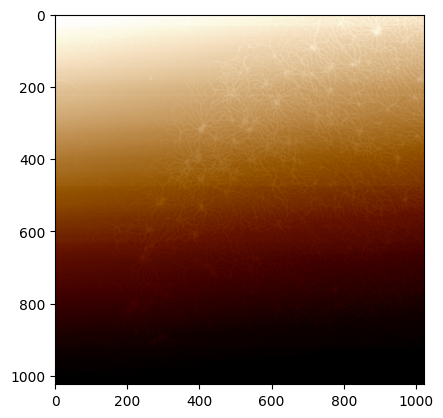

In [4]:
    #Zoom
file = Path('./PristineZoom/20230125_KPN005_25mMMgCl2_Vac.0_00009.spm')
loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw, cmap=cmap)

In [71]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    row_alignment_quantile=0.05,
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Thu, 20 Apr 2023 10:48:09] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : Median flattening without mask
[Thu, 20 Apr 2023 10:48:10] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : Plane tilt removal without mask
[Thu, 20 Apr 2023 10:48:11] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : x-polyfit 1st order: [-0.00532818  5.32807387]
[Thu, 20 Apr 2023 10:48:11] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : y-polyfit 1st order: [-2.55270905e-04  2.86789761e+00]
[Thu, 20 Apr 2023 10:48:11] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : Removing x plane tilt
[Thu, 20 Apr 2023 10:48:12] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : removing y plane tilt
[Thu, 20 Apr 2023 10:48:14] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : Remove quadratic bow 

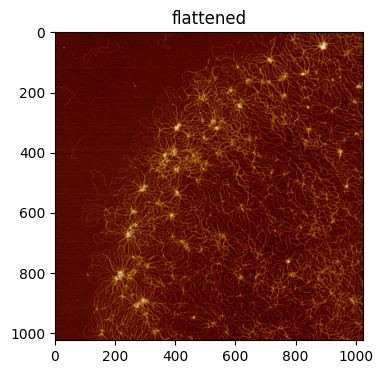

In [73]:
flattened = filters.images['zero_average_background']
plot(flattened, title='flattened',figsize=(4,4))

thresholds: defaultdict(None, {'upper': 1.8826070783448021})
[Thu, 20 Apr 2023 11:14:35] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 1.8826070783448021


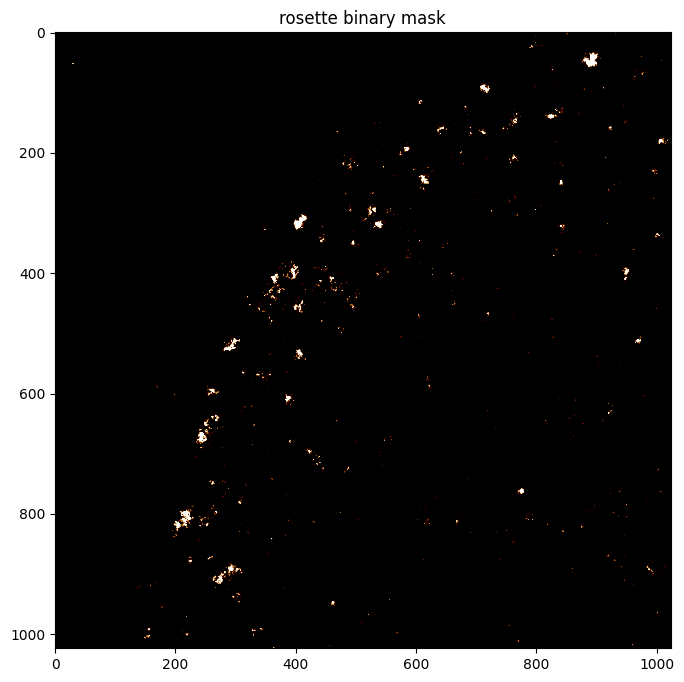

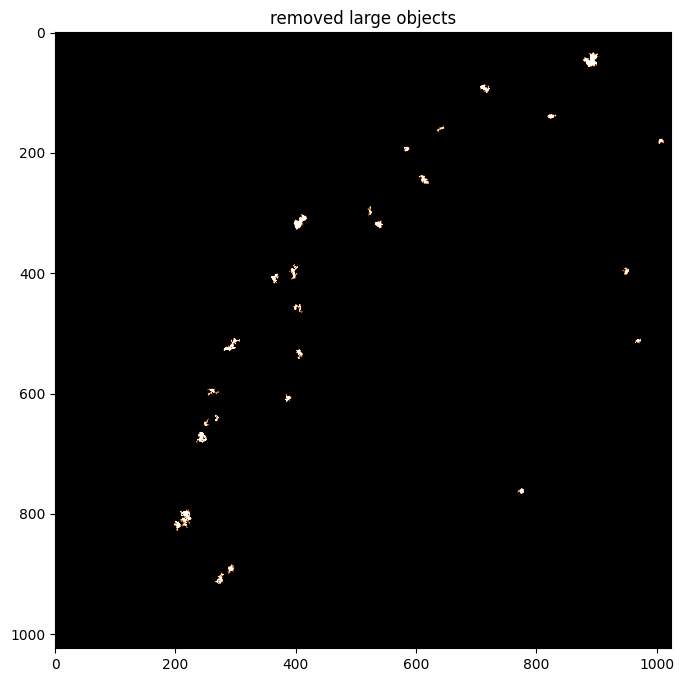

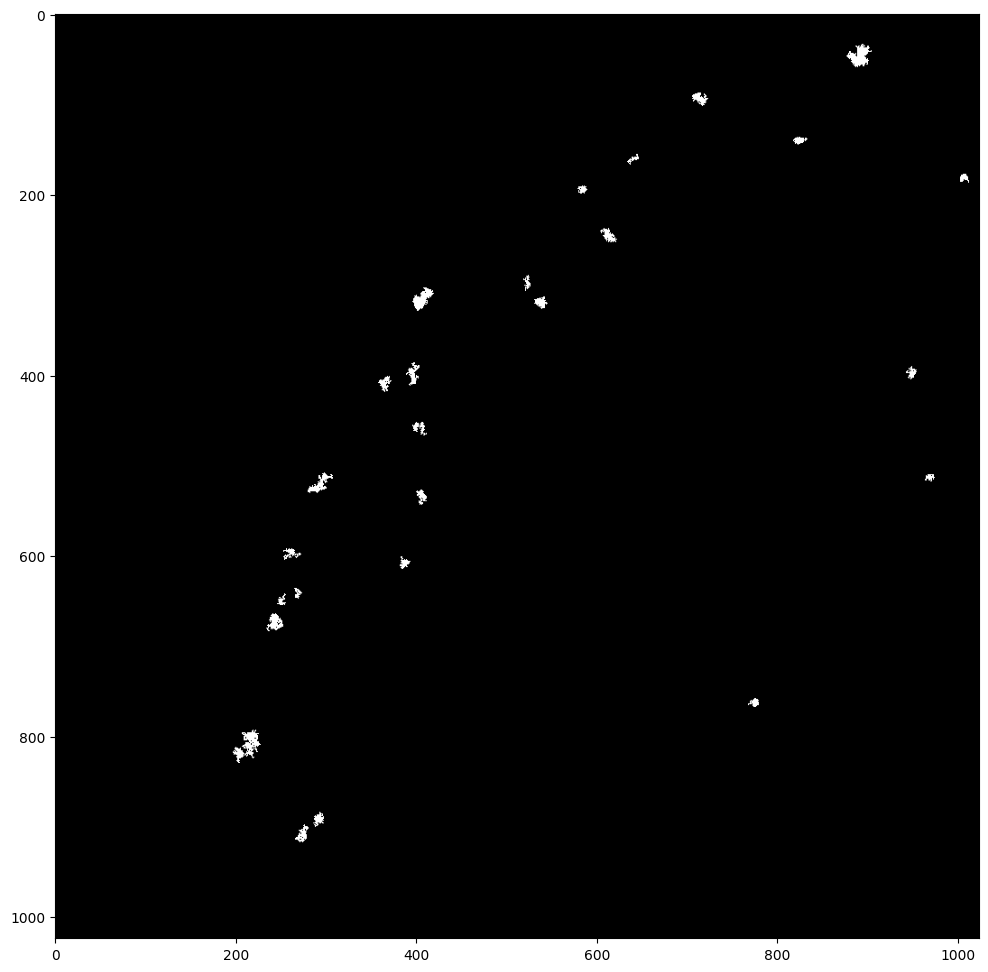

In [74]:
rosette_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 3, 'lower': None}
)

print(f'thresholds: {rosette_thresholds}')
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask.astype(bool), title='rosette binary mask', zlimit=False)

# Remove small objects
removed_small_objects = remove_small_objects(rosette_mask, 50)
# Remove large objects
labelled_rosette_mask = label(removed_small_objects)
regions = regionprops(labelled_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > 750:
        labelled_rosette_mask[labelled_rosette_mask==props.label] = 0

plot(labelled_rosette_mask.astype(bool), title='removed large objects', zlimit=False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(labelled_rosette_mask.astype(bool), cmap='gray')


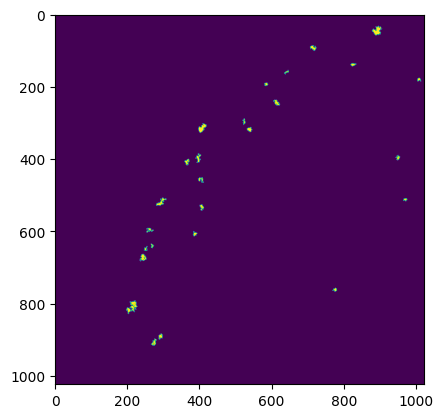

In [75]:
plt.imshow(labelled_rosette_mask.astype(bool))
plt.show()

import network_stats
#from network_stats import get_node_centroids
dir(network_stats)

node_centroids = network_stats.get_node_centroids(labelled_rosette_mask)

219.91148575128548
588.0914185364455
17
14
14
14
Out of bounds
16
15
16
16
18
17
11
13
14
19
8
15
14
15
15
16
16
9
17
19
17
[17. 14. 14. 14. 16. 15. 16. 16. 18. 17. 11. 13. 14. 19.  8. 15. 14. 15.
 15. 16. 16.  9. 17. 19. 17.]
Average:coordination 15.0
Peak Areas: [[1.863020173315749, 0.8420647471139484, 1.947858523960554, 2.2343484910092055, 0.09453231215350458, 0.38668027012285866, 3.56739453807923, 5.442435373601205, 4.594716997006053, 9.46820550210278, 5.026017070352295, 3.6427691952973626, 6.092933043694746, 2.119440837976383, 2.9902149196486363, 1.9592265783797358, 1.6442989402905306], [2.014920472209609, 4.124296135237208, 3.2504846938714476, 6.1398687419345475, 6.7356325704279785, 0.0285771276699198, 7.129282548108689, 0.17660865948012247, 2.4465106258372153, 1.3229126564051896, 4.184658869085201, 2.913541201815585, 1.9244286549888499, 3.9426986038184304], [1.624747065879322, 1.3555022466322284, 4.96580217401065, 2.1207485104935193, 1.2227920889066104, 3.25256070014608, 6.11111

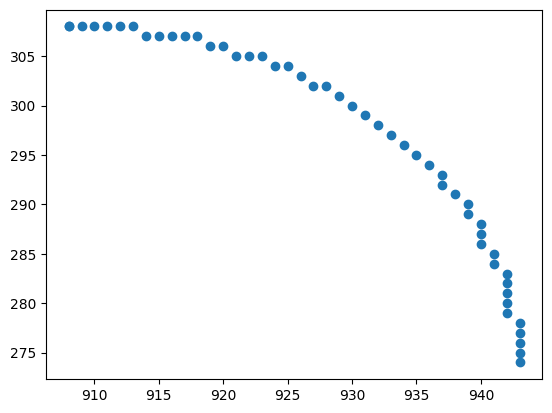

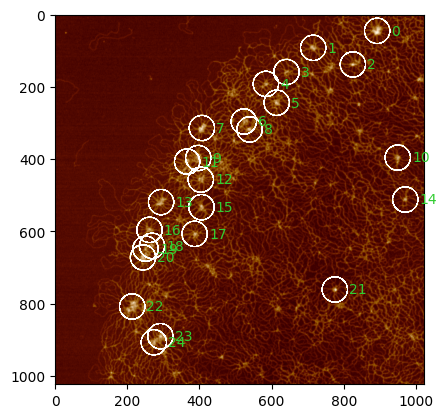

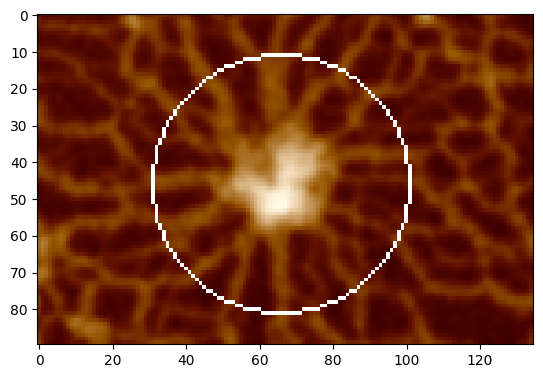

In [109]:
#Create circular masks around each nodes and extract heights
circle_mask = gaussian(flattened.copy(), sigma=1.0)
circle_image = gaussian(flattened.copy(), sigma=1.0)
radius =  35
circ_nm = radius*2*np.pi*p_to_nm
print(circ_nm/p_to_nm)
print(circ_nm)
region_values,included,area_tot,counts,region_peakarea,strand_counts = [],[],[],[],[],[]

# Function to find angle of point from centroid
def angle(point, centroid):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)

# need a list of centroids of the circles that satisfy
# the conditions, so we can label them in the image
# iteratively
filtered_circle_centroids = []
for centroid in node_centroids:
    rr,cc = draw.circle_perimeter(int(centroid[0]), int(centroid[1]), radius, method='bresenham')
    inc_nm = circ_nm/len(rr)
    background = 0.75
    if any((i<0 or i>1024) for i in rr) or any((j<0 or j>1024) for j in cc):
        print("Out of bounds")
    else:  
        #separates rr,cc into XY pairs
        XY = [i for i in zip(rr,cc)]
        # Sort the points based on their angles around the centroid
        indices = ((np.argsort([angle(point, centroid) for point in XY])))
        sorted,rr_sort,cc_sort = [],[],[]
        for i in indices:
            sorted.append(XY[i])
        for j in sorted:
            rr_sort.append(j[0])
            cc_sort.append(j[1])

        perimeter_values = circle_mask[rr_sort,cc_sort]
        perimeter_strands = np.clip(circle_mask[rr_sort,cc_sort]-0.5,0,1000)

        prev,count,trparea = 0,0,0
        peak_areas = []

        for height in perimeter_strands:
            if height > 0 and prev >= 0:
                trparea = trparea + 0.5*(height-prev)*inc_nm + prev*inc_nm 
            elif height == 0 and prev > 0:
                trparea = trparea + 0.5*(height-prev)*inc_nm + prev*inc_nm 
                peak_areas.append(trparea)
                trparea = 0
            prev = height
        strand_count = len(peak_areas)
        print(strand_count)
        strand_counts= np.append(strand_counts,strand_count)
        region_peakarea.append(peak_areas)
        region_values.append(perimeter_values)

        circle_image[rr_sort,cc_sort] = 100
        area_tot = np.trapz(region_values,dx=5)
        #print("Area:",area_tot)
        #plt.text(point[0],point[1],"1",fontsize=1)

        filtered_circle_centroids.append(centroid)
print(strand_counts)
print("Average:coordination",(sum(strand_counts)/len(strand_counts)))
#print(strand_counts)
print("Peak Areas:",region_peakarea)
plt.scatter(rr_sort[0:50],cc_sort[0:50])
plt.show()
# plot(circle_image)
plt.imshow(circle_image, vmin=-3, vmax=4, cmap=cmap)
for index, centroid in enumerate(filtered_circle_centroids):
    plt.text(centroid[1]+40, centroid[0]+10, f'{index}', color='limegreen')
plt.show()
subsection = circle_image[0:90, 825:960]
plt.imshow(subsection, vmin=-3, vmax=4, cmap=cmap)
plt.show()



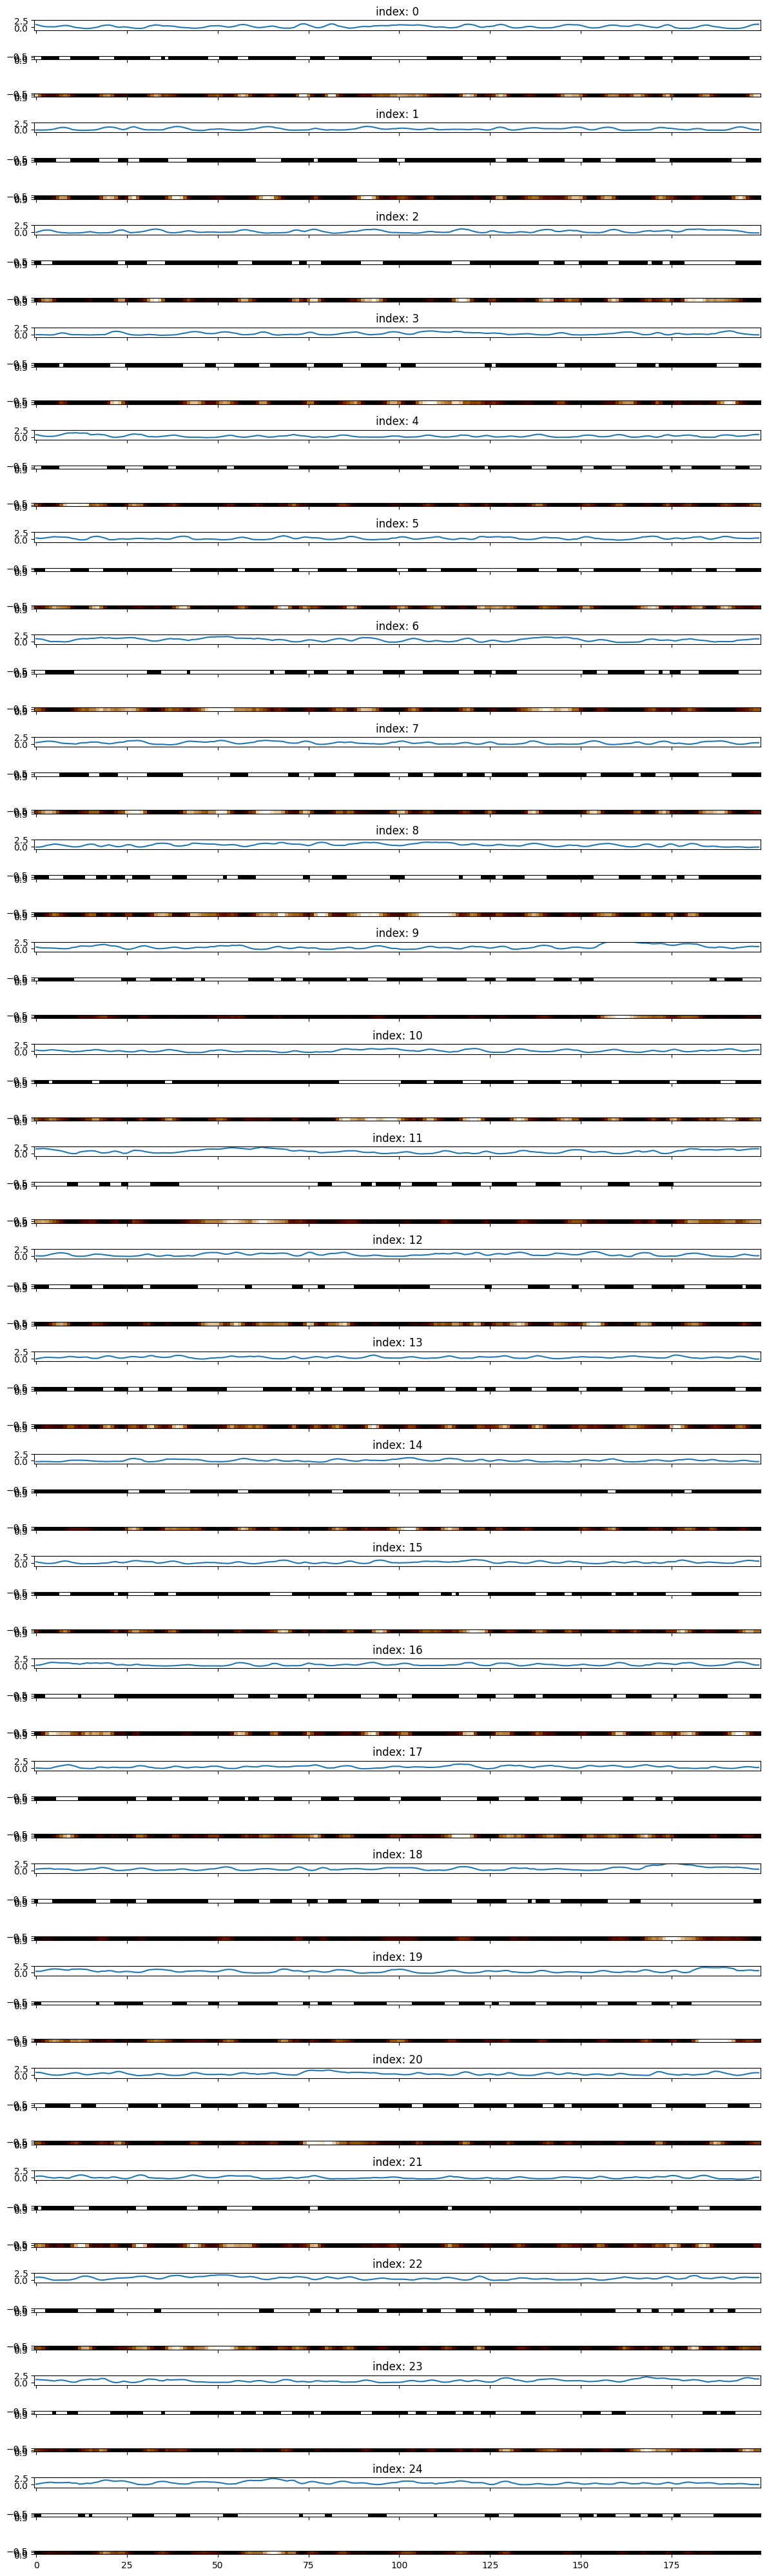

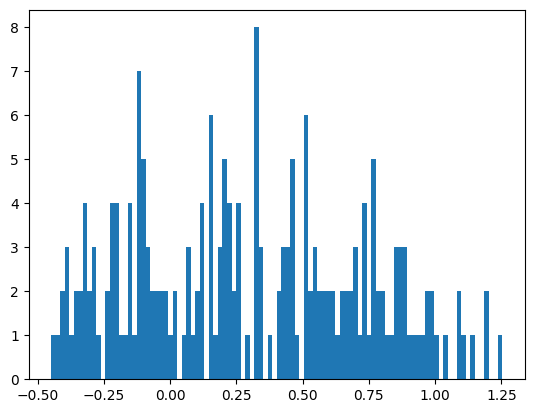

"\n#Single plot\ni = 0\nvalues = region_values[0]\nfor j in values:\n    print(j)\nfor k,point in enumerate(values):\n    print(inc_nm*k)\nfig, ax = plt.subplots(3,1,figsize=(12, 3), sharex=True)\nax[0].set_ylim(-1, 2.5)\nax[0].plot(values)\nax[1].imshow(np.array([values > 0.5]), cmap=cmap)\nax[2].imshow(np.array([values]), cmap=cmap)\nax[0].set_title(f'index: {i}')\nfig.tight_layout()\nplt.show()\n#"

In [110]:
height_ratios = [1, 2, 2]*25
fig, ax = plt.subplots(len(region_values*3),1,figsize=(12, 40), sharex=True, gridspec_kw={'height_ratios': height_ratios})
for i, values in enumerate(region_values):
    ax[i*3].set_ylim(-1, 2.5)
    ax[i*3].plot(values)
    ax[i*3+1].imshow(np.array([values > 0.5]), cmap=cmap)
    ax[i*3+2].imshow(np.array([values]), cmap=cmap)
    ax[i*3].set_title(f'index: {i}')
fig.tight_layout()
plt.show()
index = 0
values = region_values[index]
fig, ax = plt.subplots()
ax.hist(values, bins=100)
plt.show()
"""
#Single plot
i = 0
values = region_values[0]
for j in values:
    print(j)
for k,point in enumerate(values):
    print(inc_nm*k)
fig, ax = plt.subplots(3,1,figsize=(12, 3), sharex=True)
ax[0].set_ylim(-1, 2.5)
ax[0].plot(values)
ax[1].imshow(np.array([values > 0.5]), cmap=cmap)
ax[2].imshow(np.array([values]), cmap=cmap)
ax[0].set_title(f'index: {i}')
fig.tight_layout()
plt.show()
#"""